In [ ]:
#Install libraries
!pip3 install transformers
!pip3 install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

In [ ]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [7]:
!git clone https://github.com/ChaymaeJhabli/FederatedLearning.git

Cloning into 'FederatedLearning'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 666.06 KiB | 19.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
df = pd.read_csv('./FederatedLearning/data/dep1_sentiment_tweets3.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,just had a real good moment. i missssssssss hi...,0
1,1,is reading manga http://plurk.com/p/mzp1e,0
2,2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,3,@lapcat Need to send 'em to my accountant tomo...,0
4,4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
import pandas as pd

df = pd.DataFrame(df)
#Shuffling the DataFrame prevents the model from learning any patterns or biases based on the inherent order of the data
# Shuffle the DataFrame
df = df.sample(frac=1.0, replace=False)

#First 20 lines
print(df.head(20))

       Unnamed: 0                                              tweet  target
8618         8618  When monty and I read a list of all the great ...       0
11820       11820  Many health conditions can affect your #sleep ...       1
8661         8661  Roses are pine green buttercups are aliceblue ...       0
4439         4439  L4D2, lookin' good  How come I have a feeling ...       0
10483       10483  I have to pick up all the pieces of my heart &...       1
353           353                  @jonasbrothers iloveloveloveyou!        0
4562         4562  @thebeatfreaks thank you so much for coming to...       0
5960         5960  @GoldLabeler Oooh... did you take pictures. I ...       0
12946       12946             Drax the destroyer cured my depression       1
1660         1660       @joeywargachuk Heh, that is fine. Forgiven!        0
11293       11293  see I've learned a lot about myself through RP...       1
11148       11148  Came up here, a new life, after the last divor...       1

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['tweet'] = df['tweet'].apply(clean_text)


##Partitioning

###IID

In [ ]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [ ]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)

  return client_dict

# MAIN

## MODELS

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [ ]:
model = DistillBERTClass()
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [ ]:
#Initialization
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
# Dataset class
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        return self.data.target.values.tolist()

    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len



In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_len, idxs):
        self.data = dataset
        self.idxs = list(idxs)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, index):
        title = str(self.data.tweet[self.idxs[index]])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[self.idxs[index]], dtype=torch.long)
        }


In [ ]:
# ClientUpdate class
class ClientUpdate(object):
    def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=512):
        self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=4, shuffle=True)
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.epochs = epochs

    def calcuate_accu(self, big_idx, targets):
        n_correct = (big_idx==targets).sum().item()
        return n_correct

    def train(self):
        epochloss, epochacc = [], []

        for epoch in range(1, self.epochs+1):
            tr_loss = 0
            n_correct = 0
            nb_tr_steps = 0
            nb_tr_examples = 0
            self.model.train()

            for _, data in enumerate(self.train_loader, 0):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                outputs = self.model(ids, mask)
                loss = self.loss_function(outputs, targets)
                tr_loss += loss.item()
                big_val, big_idx = torch.max(outputs.data, dim=1)
                n_correct += self.calcuate_accu(big_idx, targets)

                nb_tr_steps += 1
                nb_tr_examples += targets.size(0)

                if _ % 5000 == 0:
                    loss_step = tr_loss / nb_tr_steps
                    accu_step = (n_correct * 100) / nb_tr_examples
                    print(f"Training Loss per 5000 steps: {loss_step}")
                    print(f"Training Accuracy per 5000 steps: {accu_step}")

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
            epoch_loss = tr_loss / nb_tr_steps
            epoch_accu = (n_correct * 100) / nb_tr_examples
            print(f"Training Loss Epoch: {epoch_loss}")
            print(f"Training Accuracy Epoch: {epoch_accu}")
            print("-------------------------------")
            epochloss.append(epoch_loss)
            epochacc.append(epoch_accu)

        return self.model.state_dict(), epochacc[-1], epochloss[-1]


In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8

# Split the full dataset into a train and test set
train_dataset1 = df.sample(frac=train_size, random_state=200)
val_dataset = df.drop(train_dataset1.index).reset_index(drop=True)
train_dataset1 = train_dataset1.reset_index(drop=True)

# Further split the training dataset into a training and validation set
train_dataset = train_dataset1.sample(frac=train_size, random_state=200)
test_dataset = train_dataset1.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

# Print the sizes of the datasets
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION  Dataset: {}".format(test_dataset.shape))
print("TEST Dataset: {}".format(val_dataset.shape))

# Create dataset objects using the Triage class
training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)
validating_set = Triage(val_dataset, tokenizer, MAX_LEN)


FULL Dataset: (13513, 3)
TRAIN Dataset: (8648, 3)
VALIDATION  Dataset: (2162, 3)
TEST Dataset: (2703, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validating_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
import copy

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(train_acc, val_acc_list):
    plt.figure(figsize=(10, 5))
    x_axis = np.arange(1, len(train_acc) + 1)
    plt.plot(x_axis, train_acc, label='Train Accuracy', color='tab:orange')
    plt.plot(x_axis, val_acc_list, label='Validation Accuracy', color='tab:blue')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Accuracy')
    plt.title("Training and Validation Accuracy vs. Global Rounds")
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

def plot_loss(train_loss, val_loss_list):
    plt.figure(figsize=(10, 5))
    x_axis = np.arange(1, len(train_loss) + 1)
    plt.plot(x_axis, train_loss, label='Train Loss', color='tab:red')
    plt.plot(x_axis, val_loss_list, label='Validation Loss', color='tab:green')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Loss')
    plt.title("Training and Validation Loss vs. Global Rounds")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()


In [ ]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E, plt_color, patience=3):
    global_weights = model.state_dict()
    train_loss, train_acc = [], []
    val_acc_list = []
    val_loss_list = []
    early_stopping = EarlyStopping(patience=patience)

    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    start = time.time()

    for curr_round in range(1, rounds + 1):
        w, local_loss, local_acc = [], [], []
        m = max(int(C * K), 1)
        S_t = np.random.choice(range(K), m, replace=False)

        for k in S_t:
            local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                        optimizer=optimizer, epochs=E, idxs=data_dict[k])
            weights, acc, loss = local_update.train()

            w.append(copy.deepcopy(weights))
            local_loss.append(copy.deepcopy(loss))
            local_acc.append(copy.deepcopy(acc))

        # Mise à jour des poids globaux
        weights_avg = copy.deepcopy(w[0])
        for k in weights_avg.keys():
            for i in range(1, len(w)):
                weights_avg[k] += w[i][k]

            weights_avg[k] = torch.div(weights_avg[k], len(w))

        global_weights = weights_avg
        model.load_state_dict(global_weights)

        # Calcul de la perte et de la précision moyennes
        loss_avg = sum(local_loss) / len(local_loss)
        acc_avg = sum(local_acc) / len(local_acc)
        print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
        print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
        train_loss.append(loss_avg)
        train_acc.append(acc_avg)

        # Validation accuracy et loss
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        with torch.no_grad():
            for data in testing_loader:
                ids = data['ids'].to(device, dtype=torch.long)
                mask = data['mask'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.long)

                outputs = model(ids, mask)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_acc = (val_correct / val_total) * 100
        val_loss /= len(testing_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        print('Round: {}... \tValidation Accuracy: {}'.format(curr_round, round(val_acc, 3)))
        print('Round: {}... \tValidation Loss: {}'.format(curr_round, round(val_loss, 3)))

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    end = time.time()

    # Charger le meilleur modèle
    model.load_state_dict(early_stopping.best_model)

    # Après la boucle d'entraînement
    plot_accuracy(train_acc, val_acc_list)
    plot_loss(train_loss, val_loss_list)


    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))

    return model


Training Loss per 5000 steps: 0.6411665678024292
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 82.17592592592592
Training Loss Epoch: 0.43542404500422655
Training Accuracy Epoch: 82.17592592592592
-------------------------------
Training Loss per 5000 steps: 0.09144684672355652
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 92.01388888888889
Training Loss Epoch: 0.24911277603220056
Training Accuracy Epoch: 92.01388888888889
-------------------------------
Training Loss per 5000 steps: 0.03132227808237076
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 92.01388888888889
Training Loss Epoch: 0.26736186943189416
Training Accuracy Epoch: 92.01388888888889
-------------------------------
Round: 1... 	Average Loss: 0.317
Round: 1... 	Average Accuracy: 88.735
Round: 1... 	Validation Accuracy: 92.784
Round: 1... 	Validation Loss: 0.252
Training Loss per 5000 steps: 0.04331023246049881
Training Accuracy per 5000 steps: 1

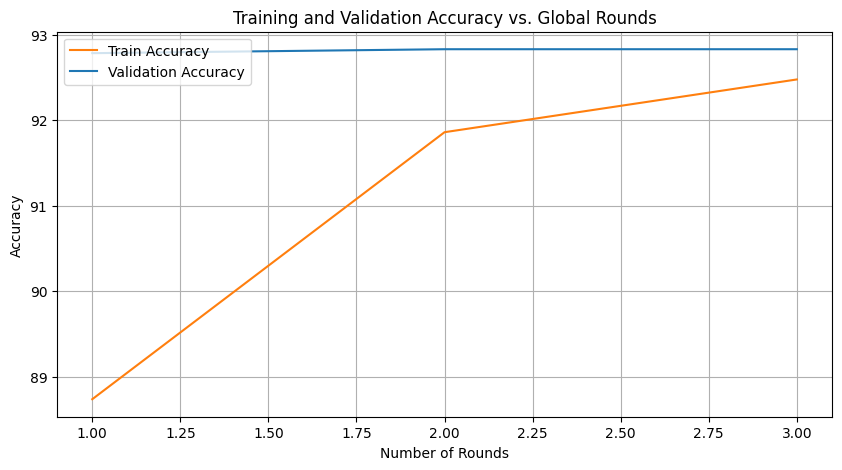

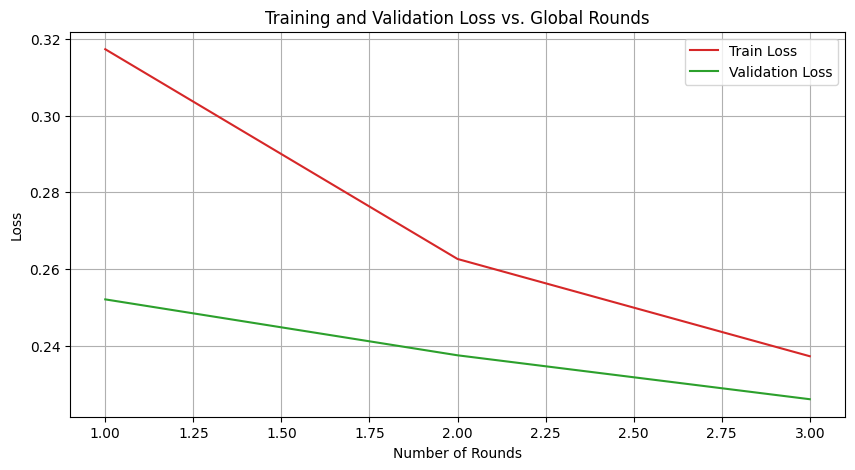

Training Done!
Total time taken to Train: 476.54039216041565


In [ ]:
if torch.cuda.is_available():
  model.cuda()

distilbert_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange", patience=3)

In [ ]:
def calcuate_accu(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [ ]:
#Testing the trained model
def Test(model, testing_loader, loss_function):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu

In [ ]:
print('This is the Test section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch')

acc = Test(distilbert_iid_trained, validating_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

This is the Test section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.23123103380203247
Validation Accuracy per 100 steps: 93.75
Validation Loss Epoch: 0.2611386322799851
Validation Accuracy Epoch: 91.12097669256381
Accuracy on test data = 91.12%


Training Loss per 5000 steps: 0.0453067272901535
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.016171642336994408
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 0.006425723899155855
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 99.0
Training Loss Epoch: 0.03440092045813799
Training Accuracy Epoch: 99.0
-------------------------------
Training Loss per 5000 steps: 0.0033207572996616364
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.0027455873042345046
Training Accuracy Epoch: 100.0
-------------------------------
Round: 1... 	Average Loss: 0.018
Round: 1... 	Average Accuracy: 99.667
Round: 1... 	Validation Accuracy: 81.129
Round: 1... 	Validation Loss: 0.835
Training Loss per 5000 steps: 0.0030325930565595627
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.

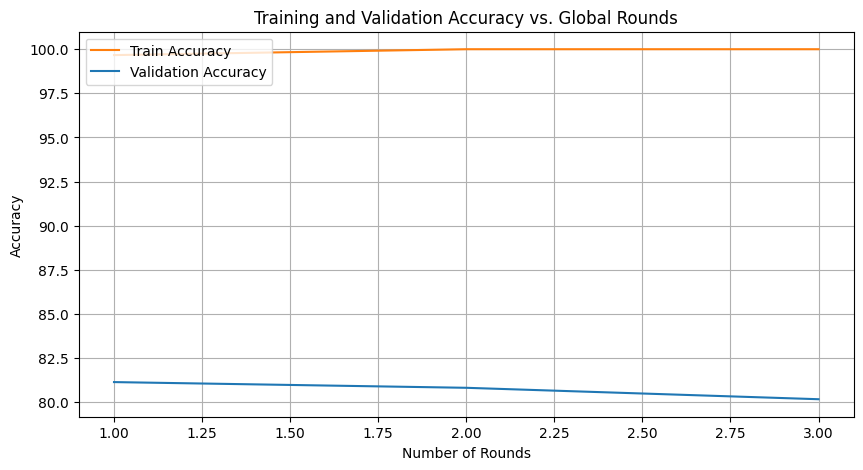

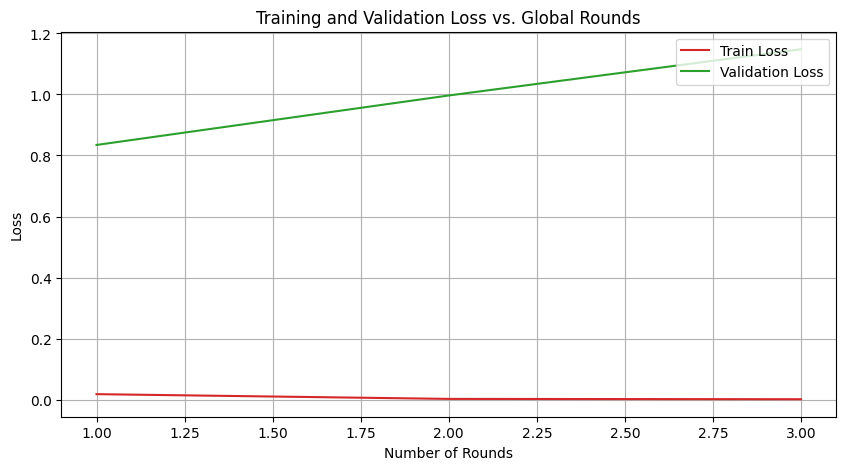

Training Done!
Total time taken to Train: 148.198890209198


In [ ]:
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)

if torch.cuda.is_available():
  model.cuda()

distilbert_non_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange", patience=3)

In [ ]:
print('This is the Test section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch')

acc = Test(distilbert_non_iid_trained, validating_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

This is the Test section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the Test dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.737801194190979
Validation Accuracy per 100 steps: 75.0
Validation Loss Epoch: 0.878030288219452
Validation Accuracy Epoch: 80.83610802811691
Accuracy on test data = 80.84%
